In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("ggplot")

warnings.filterwarnings("ignore")

# Importing data

In [ ]:
tps_july = pd.read_csv(
    "https://raw.githubusercontent.com/harinyadevi/Time-series-and-analysis/main/train.csv",
    parse_dates=["date_time"],
    index_col="date_time",
)

# Autocorrelation

In [ ]:
deg_C = tps_july["deg_C"].to_frame("temperature")

deg_C.head()

,temperature
date_time,
2010-03-10 18:00:00,13.1
2010-03-10 19:00:00,13.2
2010-03-10 20:00:00,12.6
2010-03-10 21:00:00,11.0
2010-03-10 22:00:00,11.9


## Checking for different lags

In [ ]:
deg_C["lag_1"] = deg_C["temperature"].shift(periods=1)
deg_C["lag_2"] = deg_C["temperature"].shift(periods=2)
deg_C["lag_3"] = deg_C["temperature"].shift(periods=3)

deg_C.head(6)

,temperature,lag_1,lag_2,lag_3
date_time,,,,
2010-03-10 18:00:00,13.1,NaN,NaN,NaN
2010-03-10 19:00:00,13.2,13.1,NaN,NaN
2010-03-10 20:00:00,12.6,13.2,13.1,NaN
2010-03-10 21:00:00,11.0,12.6,13.2,13.1
2010-03-10 22:00:00,11.9,11.0,12.6,13.2
2010-03-10 23:00:00,11.2,11.9,11.0,12.6


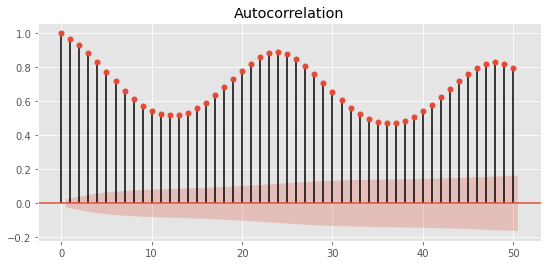

In [ ]:
from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf

rcParams["figure.figsize"] = 9, 4
# ACF function up to 50 lags
fig = plot_acf(deg_C["temperature"], lags=50)

plt.show();

Autocorrelation plot - If the height of the bars is outside this confidence interval, it means the correlation is statistically significant.

The X axis is the lag k, and the Y axis is the Pearson's correlation coefficient at each lag.

The Autocorrelation Function (ACF) finds the correlation coefficient between a time series and its lagged version at each lag k. 

# Sample white noise with random numbers

White noise distribution is any distribution that has:

Zero mean

A constant variance/standard deviation (does not change over time)

Zero autocorrelation at all lags

If the noise is normal (follows a normal distribution), it is called Gaussian white noise.

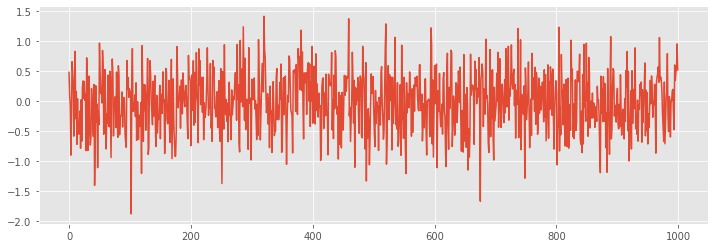

In [ ]:
noise = np.random.normal(loc=0, scale=0.5, size=1000)

plt.figure(figsize=(12, 4))
plt.plot(noise);

# Gaussian white noise sample distribution with mean 0 and 0.5 std

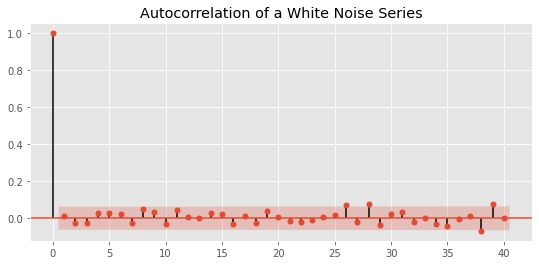

In [ ]:
fig = plot_acf(noise, lags=40)

plt.title("Autocorrelation of a White Noise Series")
plt.show()

White noise distributions have approximately 0 autocorrelation at all lags.

# White noise for the chosen dataset

In time series forecasting, if the differences between predictions and actual values represent a white noise distribution, then we can be sure that our model is pretty good.

The following example shows predicting the amount of carbon monoxide in the air using the chosen dataset.

In [ ]:
X = tps_july.drop(
    ["target_carbon_monoxide", "target_benzene", "target_nitrogen_oxides"], axis=1
)
y = tps_july["target_carbon_monoxide"].values.reshape(-1, 1)

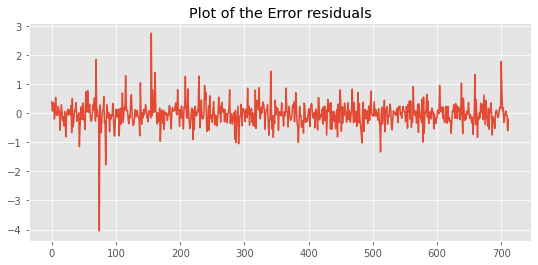

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1
)

forest = RandomForestRegressor()
forest.fit(X_train, y_train)

preds = forest.predict(X_test)
residuals = y_test.flatten() - preds

plt.plot(residuals)
plt.title("Plot of the Error residuals");

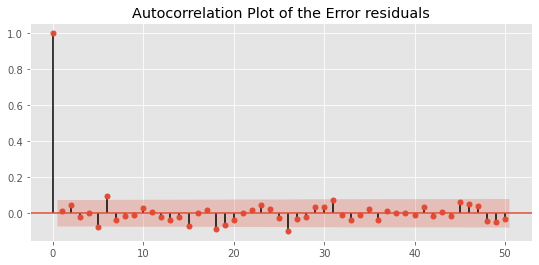

In [ ]:
fig = plot_acf(residuals, lags=50)

plt.title("Autocorrelation Plot of the Error residuals")
plt.show();

There is some pattern in the ACF plot, but they are within the confidence interval. These two plots suggest that Random Forests could capture almost all the important signals from the training data even with default parameters.

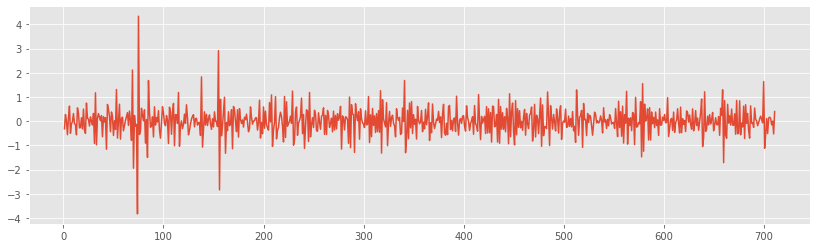

In [ ]:
rcParams["figure.figsize"] = 14, 4
walk_diff = pd.Series(residuals).diff()

plt.plot(walk_diff);

Since it is tough to visualize a random walk just from the plots, we go for p-test.

In [ ]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(tps_july["target_carbon_monoxide"])

print(f"ADF Statistic: {results[0]}")
print(f"p-value: {results[1]}")
print("Critical Values:")
for key, value in results[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -8.98210258477202
p-value: 7.263413572495717e-15
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The p-value is extremely small, suggesting we can easily reject the null hypothesis that target_carbon_monoxide follows a random walk.